### From LinkedIn Learning
https://www.linkedin.com/learning/python-for-data-science-essential-training-part-2/logistic-regression-treat-missing-values?u=36492188

In [42]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics  # why need this line?
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [44]:
%matplotlib inline
rcParams['figure.figsize'] = 5,4
sb.set_style('whitegrid')

### Logistic Regression on the Titanic Dataset

In [45]:
address = "data/titanic-training-data.csv"
titanic_training = pd.read_csv(address)
titanic_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
# don't really need the following, it is already in the csv header file
# titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
titanic_training.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [47]:
titanic_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

<AxesSubplot:xlabel='Survived', ylabel='count'>

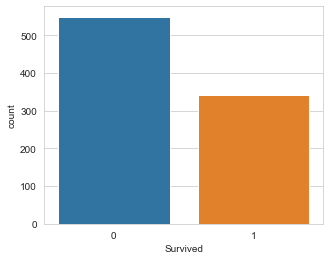

In [48]:
# target is Surivied column
sb.countplot(x='Survived', data=titanic_training)

### Checking for missing values

In [49]:
titanic_training.isnull().sum()
# missing value is also in the info() called above

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
# using describe() to check for missing records.  Note Age has 714 count.  But only numerical columns showed.  Embark not shown.
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [51]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

<AxesSubplot:xlabel='Parch', ylabel='Age'>

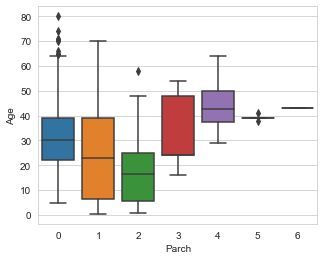

In [52]:
# Age is missing data.  891 vs 714 (see count above)
# Look at the Parch and Age relationship
sb.boxplot(x='Parch', y='Age', data=titanic_data)

 Here we can see for younger age, the Parch is 1 or 2. For children, likely to have 1 or more parent onboard.
 For Parch 4, the age is from 39 - 50.  This indicate the parent having children with them onboard.
 Using this data to impute missing values in Age column.

In [53]:
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [54]:
# going to use data in Parch to impute data for Age
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    if pd.isnull(Age):
        if Parch == 0:
            return 32 # mean for the Parch group
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30 # mean of the whole ship
    else:
        return Age        

In [55]:
titanic_data['Age'] = titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [56]:
# still missing values in Embarked column
# only 2 records, dropping it should not affect much, so drop the 2 records.
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)
titanic_data.info()  # 889 records left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB


### Converting categorical variables to a dummy indicators

In [57]:
# reformat Sex, Embark columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 0, 0, 1])

In [58]:
# what is 1 or 0?  Check the dataframe
titanic_data.head()
# 1 = Male, 2 = Female

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [59]:
gender_DF = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [60]:
# now work on Embark
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

In [61]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_DF = pd.DataFrame(embarked_1hot_mat, columns=['C','Q','S'])
embarked_DF.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [62]:
titanic_data.drop(['Sex','Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [63]:
# concatenate the generated dataframe as columns)
titanic_dmy = pd.concat([titanic_data, gender_DF, embarked_DF], axis=1, verify_integrity=1)
titanic_dmy[0:5]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,1,0.0,0.0,1.0


### Checking for independence between features

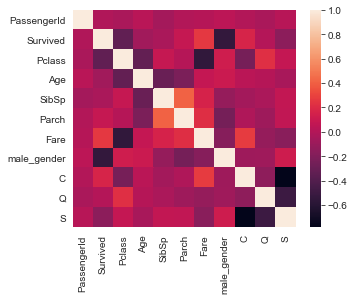

In [64]:
# use heatmap to check for corelations
sb.heatmap(titanic_dmy.corr());
# if the value is close to 1 or -1, it means there is a strong corelation bert the variables

### Logistic Regression assumption
#### Independent variables/Features are independent of each other
Look for 1 (light color) or -1 (dark color)

PClass vs Fare is correlated, so need to drop 1 of them.

In [65]:
# Why drop both?  Should not I just drop 1 of them.
titanic_dmy = titanic_dmy.drop(['Pclass','Fare'], axis=1)
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
0,1,0,22.0,1,0,1,0.0,0.0,1.0
1,2,1,38.0,1,0,0,1.0,0.0,0.0
2,3,1,26.0,0,0,0,0.0,0.0,1.0
3,4,1,35.0,1,0,0,0.0,0.0,1.0
4,5,0,35.0,0,0,1,0.0,0.0,1.0


### Checking that your dataset size is sufficient
Good rule of thumb is that we should have 50 records per predictive features<br>
How many predictive variables?  
We have 6 predictive features.  C|Q|S is considered 1 as they are dummy variables for Embarked<br>
thus, we need at least 50x6 records for this model.

In [66]:
titanic_dmy.info()
# we have 889 records.  Thus we have enough to run the regression.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    int64  
 4   Parch        889 non-null    int64  
 5   male_gender  889 non-null    int32  
 6   C            889 non-null    float64
 7   Q            889 non-null    float64
 8   S            889 non-null    float64
dtypes: float64(4), int32(1), int64(4)
memory usage: 59.2 KB


### Split the Data into Training and Test for Logistic Regression

In [70]:
# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(titanic_dmy.drop('Survived',axis=1), titanic_dmy['Survived'], test_size=0.2, random_state=200)

In [71]:
print(X_train.shape)
print(y_train.shape)

(711, 8)
(711,)


In [73]:
# print out to check the data and see the columns are ok
X_train[0:5]

,PassengerId,Age,SibSp,Parch,male_gender,C,Q,S
719,721,6.0,0,1,0,0.0,0.0,1.0
165,167,24.0,0,1,0,0.0,0.0,1.0
879,882,33.0,0,0,1,0.0,0.0,1.0
451,453,30.0,0,0,1,1.0,0.0,0.0
181,183,9.0,4,2,1,0.0,0.0,1.0


### Deploying and evaluating the model

In [74]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [75]:
y_pred = LogReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       109
           1       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



We are getting 0.81 (81%) accuracy, not bad

### K-fold cross-validation & confusion matrices

In [79]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[377,  63],
       [ 91, 180]], dtype=int64)

In [ ]:
# 377, 180 is the correct prediction.  True Positive and True Negative

In [80]:
precision_score(y_train, y_train_pred)

0.7407407407407407

### Make a test prediction

In [82]:
# Create a fake record for testing
# Look at one existing record, use as source
titanic_dmy[863:864]

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
863,866,1,42.0,0,0,0,0.0,0.0,1.0


In [84]:
# set up the fake record based on the the record above
test_passenger = np.array([866, 40, 0, 0, 0, 0, 0, 1]).reshape(1,-1)
print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1]
[[0.26351831 0.73648169]]


### Compare the result prediction of the fake passenger with the actual record
Both Survived<br>
The prediction is73% chance correct